In [ ]:
# important imports
# !pip install opencv-python
# !pip install patchify
# !pip install GPUtil
# !pip install torchsummary
# !pip install tqdm
# !pip install albumentations

In [4]:

from GPUtil import showUtilization as gpu_usage

import sys
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
# import seaborn as sns
import os
import cv2
# import random
import glob
import PIL
from PIL import Image
from tqdm import tqdm
import imghdr
from patchify import patchify 


import time
import torch
import torchvision
import torch.optim as optim
import albumentations as A
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torch.nn import Dropout
# from torchsummary import summary
from torchinfo import summary
from torch.nn import BatchNorm2d 

from torchvision.transforms import CenterCrop
from torch.nn import functional as F
from torch.nn.functional import normalize

- source_tutorial: https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
- unet: https://github.com/milesial/Pytorch-UNet
- Probablistic_unet: https://github.com/stefanknegt/Probabilistic-Unet-Pytorch/blob/master/probabilistic_unet.py
- utility script: https://github.com/CaptainDredge/Image-segmentation-utilities
- GPU_utility: https://github.com/anderskm/gputil
- torch_em: https://github.com/computational-cell-analytics/dl-for-micro/blob/main/2_cell_segmentation/torchem-train-cell-membrane-segmentation.ipynb
- torch_em: https://github.com/constantinpape/torch-em/blob/main/torch_em/model/unet.py
- digital_sreeni: https://github.com/bnsreenu/python_for_microscopists/blob/master/206_sem_segm_large_images_using_unet_with_custom_patch_inference.py
- data_Augmentatin: https://albumentations.ai/docs/getting_started/mask_augmentation/
- learning rate https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling
- multi GPU (main device) https://discuss.pytorch.org/t/how-to-specify-a-gpu-as-the-main-gpu-in-dataparallel/154375/3
- multi GPU training https://glassboxmedicine.com/2020/03/04/multi-gpu-training-in-pytorch-data-and-model-parallelism/ -;-;-
https://blog.paperspace.com/find-optimal-batch-size/#:~:text=We%20should%20select%20the%20smallest,GPU%20is%20a%20good%20number 
- num_worker guidelines https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813
- memoery utilization https://discuss.pytorch.org/t/batch-size-and-num-workers-vs-gpu-and-memory-utilization/36494
- model summary https://discuss.pytorch.org/t/why-is-summary-of-model-need-cuda/35946
- model saving https://wandb.ai/wandb/common-ml-errors/reports/How-to-Save-and-Load-Models-in-PyTorch--VmlldzozMjg0MTE
- mdoel saving https://machinelearningmastery.com/save-and-load-your-pytorch-models/ 
- loading model states for multi-GPU  https://discuss.pytorch.org/t/solved-keyerror-unexpected-key-module-encoder-embedding-weight-in-state-dict/1686/3 
- memory pinning https://forums.developer.nvidia.com/t/advantages-disadvantages-of-using-pinned-memory/34422



### loss functionds
The validation loss function is just a metric and actually not needed for training. It's there because it make sense to compare the metrics which your network is actually optimzing on. So you can add any other loss function as metric during compilation and you'll see it during training.
- https://dev.to/_aadidev/3-common-loss-functions-for-image-segmentation-545o
- https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics/notebook
- https://github.com/JunMa11/SegLoss 
- https://pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/
- important for iunet loss and everytjing https://discuss.pytorch.org/t/unet-implementation/426/12

## cuda and model infromations 

- bsz: batch size
- lR: learning rate 1e-num
- SDG: optimiser
- ADM: Adam optimiser
- clcLR: scheduler 
- vls: validation split
- EnDc: encodert decoder channels
- pt: patience for earkly stopping
- i/p : input size 
- ep: epochs
- wd: weight decay(l2 reg)
- drp: drop out added
- 1CH: input one channel instead of RGB
- aug: num of augmentation
- nW: num_workers

In [2]:

print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
print(gpu_usage())

__Python VERSION: 3.11.2 (main, Mar 13 2023, 12:18:29) [GCC 12.2.0]
__pyTorch VERSION: 2.2.1+cu121
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
__CUDNN VERSION: 8902
__Number CUDA Devices: 8
__Devices
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, NVIDIA GeForce RTX 2080 Ti, 550.54.14, 11264 MiB, 1100 MiB, 9903 MiB
1, NVIDIA GeForce RTX 2080 Ti, 550.54.14, 11264 MiB, 7872 MiB, 3131 MiB
2, NVIDIA GeForce RTX 2080 Ti, 550.54.14, 11264 MiB, 4958 MiB, 6045 MiB
3, NVIDIA GeForce RTX 2080 Ti, 550.54.14, 11264 MiB, 8096 MiB, 2907 MiB
4, NVIDIA GeForce RTX 2080 Ti, 550.54.14, 11264 MiB, 6162 MiB, 4841 MiB
5, NVIDIA GeForce RTX 2080 Ti, 550.54.14, 11264 MiB, 2 MiB, 11001 MiB
6, NVIDIA GeForce RTX 2080 Ti, 550.54.14, 11264 MiB, 5072 MiB, 5931 MiB
7, NVIDIA GeForce RTX 2080 Ti, 55

## Setting up configuration for running in notebooks

- The pin memory is set to True to the DataLoader which will automatically put the fetched data Tensors in pinned memory, enabling faster data transfer to CUDA-enabled GPU's. For every epoch the data is transferred from CPU to GPU, with augmentations done in the CPU, and trainings done in the GPU.
- Check the output directory for saving the images, model path, plot path and test path (BASE_OUTPUT, MODEL_PATH, PLOT_PATH, TEST_PATH)
- Note keep the bacthsize small (2,5) untill you start using pacthes of the image otherwise the GPU will run out of memory

In [2]:
# define the test split
# TEST_SPLIT = 0.3
VALIDATION_SPLIT = 0.4

# determine the device to be used for training and evaluation
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
PIN_MEMORY = True #if DEVICE == "cuda" else False
print('device', DEVICE)
# determine if we will be pinning memory during data loading

print(PIN_MEMORY)

# define the number of inputchannels in the input, number of classes,
# and number of levels (start and end) in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3
START_CHANEL = 16
END_CHANEL = 256

## this has to gp below after the model initalisation and number of GPU selected
if torch.cuda.device_count() == 8:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  NUM_WORKERS = (4 * torch.cuda.device_count()) if torch.cuda.is_available() else 1 
# NUM_WORKERS = 2 

# initialize learning rate, number of epochs to train for, and the
# batch size ( in general small batch size has 256 samples, here due to 2 batch ss we have )
INIT_LR = 1e-3
NUM_EPOCHS = 10
BATCH_SIZE = 1
PATCH_SIZE = 256
WEIGHT_DECAY = 1e-6

INPUT_IMAGE_WIDTH = PATCH_SIZE
INPUT_IMAGE_HEIGHT = PATCH_SIZE
NUM_AUGMENTATION = 3
TRANSFORMS = True

#learning rate scheduler 
Patience = 4
MAX_lr = 1e-1
BASE_lr = 1e-6
STEP_SIZE = 50

# define thresholds for early stopping, for accuracy calculation and predcitions 
EARLY_STOP_THRES = 2
# best_accuracy = -1
# best_epoch = -1
THRESHOLD = 0.5


plotName = f"bSz{BATCH_SIZE}_ip{PATCH_SIZE}_EnDc{START_CHANEL}-{END_CHANEL}_ep{NUM_EPOCHS}_vls{VALIDATION_SPLIT}_aug{NUM_AUGMENTATION}_nW{NUM_WORKERS}"
print(plotName)


BASE_OUTPUT = "/user/s.chakrabarty/myoTwinWork/code/EmbryonicBodySegmentation"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, f"{plotName}")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
# TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

# define the path to the base output directory
gpu_usage() 

device cuda:1
True
Let's use 8 GPUs!
bSz1_ip256_EnDc16-256_ep10_vls0.4_aug3_nW32
| ID | GPU | MEM |
------------------
|  0 |  0% | 10% |
|  1 |  0% | 70% |
|  2 |  0% | 44% |
|  3 |  0% | 72% |
|  4 |  0% | 55% |
|  5 |  0% |  0% |
|  6 |  0% | 45% |
|  7 |  0% | 42% |


## CREATING THE CUSTOM DATASET

In [4]:
def readData(imgPath, labelPath, convertType, develop = False):
    """Reads and creates a list of target""" 
    image = []
    label = []
    imageList = []
    labelList = []
  
    for i, image_name in enumerate(sorted(os.listdir(imgPath))):
        if ((('.').join(image_name.split('.')[-1:])== 'tif') or (('.').join(image_name.split('.')[-1:]) == 'tiff')):
            label_name = '.'.join(image_name.split('.')[:-1]) +  '_bn.tif'
            
            if label_name in list(os.listdir(labelPath)): 
                # normalise by 255.0 -> convert to array -> append to list
                img_Path = os.path.join(imgPath, image_name)
                img = Image.open(img_Path).convert(convertType)
                img = np.array(img, dtype = np.float32)/255.0
                image.append(img)
                imageList.append((img_Path))
                
                label_Path = os.path.join(labelPath, label_name)
                img = Image.open(label_Path).convert(convertType)
                label.append(np.where(np.array(img) >= 1, 1.0, 0.0))
                labelList.append((label_Path))
            else:
                print('Images with no mask-->', image_name)
        else: print('Image with new extension', image_name)
        if i == 10 and develop == True:
            print('only few images for development')
            break
    print(f'total images --> {len(imageList)}, total masks --> {len(labelList)}')       
    return image, label
            
input_folder = '/user/s.chakrabarty/myoTwinWork/data/embryonicImages/Images_input'
label_folder = '/user/s.chakrabarty/myoTwinWork/data/embryonicImages/Images_target'
image, label = readData(input_folder, label_folder, convertType = 'L', develop = True)

Image with new extension .DS_Store
only few images for development
total images --> 10, total masks --> 10


/kaggle/input/myofarm/Images_target/20220714_JK_d1_diff_isRASb1_corr_13_5_uM_CHIR_220018_p17_6mio_dish_2_bn.tif

'/kaggle/input/myofarm/Images_target/20230306_JK_230008_d12_isWT1Bld_2_261_bn.tif'
'/kaggle/input/myofarm/Images_target/20230217_JK_BRAF_mc_8_p23_d9_230007_bn.tif'

Images:(1536, 2048) and mask:(1536, 2048) shape



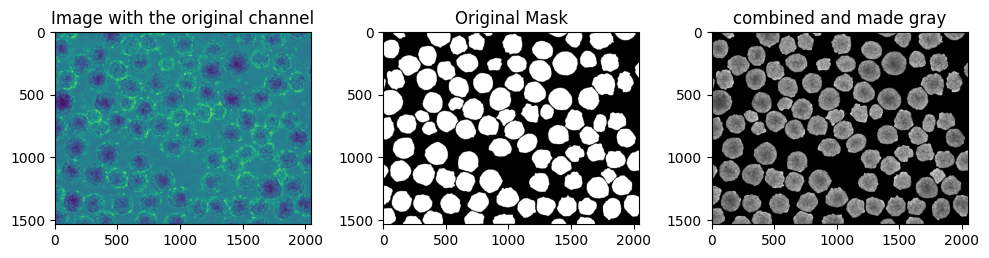

In [5]:
def plotSanityCheckImages(img1, img2):
    
    print(f'Images:{img1.shape} and mask:{img2.shape} shape\n')
    
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
    ax[0].imshow(img1)
    ax[1].imshow(img2, cmap = 'gray')
    ax[2].imshow(img2 * img1, cmap = 'gray')

    ax[0].set_title("Image with the original channel")
    ax[1].set_title("Original Mask")
    ax[2].set_title("combined and made gray")

    figure.tight_layout()
    figure.show()

plotSanityCheckImages(image[0], label[0])

In [6]:
def dataTransform(image, mask):
    images_list, masks_list = [], []
    
    transform = A.Compose([ A.HorizontalFlip(p = 0.5),
                            A.VerticalFlip(p = 0.5),
                            A.RandomBrightnessContrast(p=0.5),
                            A.ElasticTransform(p=0.5),
                            A.GridDistortion(p = 0.5), ])

    for i in range(NUM_AUGMENTATION):
        augmentations = transform(image = np.array(image), mask = np.array(mask))
        images_list.append(augmentations["image"])
        masks_list.append(augmentations["mask"])
        
    return images_list, masks_list
    
print('To check the augmentation patterns')


def createPatches(imgList, maskList, PATCH_SIZE):
    images = []
    masks = []
    for i, (image, mask) in enumerate(zip(imgList, maskList)):      
        patch_images = patchify(image, (PATCH_SIZE,PATCH_SIZE), step = PATCH_SIZE)
        patch_masks = patchify(mask, (PATCH_SIZE,PATCH_SIZE), step = PATCH_SIZE)
        
        for i in range(patch_images.shape[0]):
            for j in range(patch_images.shape[1]):
                single_patch_img = patch_images[i,j,:,:]
                images.append(single_patch_img)
                
                single_patch_img = patch_masks[i,j,:,:]
                masks.append(single_patch_img)
                
    images = torch.reshape(torch.tensor(np.array(images)), [-1,1,PATCH_SIZE,PATCH_SIZE])       
    masks = torch.reshape(torch.tensor(np.array(masks)), [-1,1,PATCH_SIZE,PATCH_SIZE])
        
    return images, masks 

class SpheroidDataset(Dataset):

    def __init__(self, imagePaths, maskPaths, transforms = None, num_augmentations = NUM_AUGMENTATION, develop = False):
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
        self.num_augmentations = num_augmentations
        self.develop = develop

        # Read and store image and mask data efficiently
        self.images, self.masks = readData(self.imagePaths, self.maskPaths, "L", self.develop)

    def __len__(self):
        if self.transforms == True:
            length = len(self.images) * self.num_augmentations
        else:
            length = len(self.images)
        print(f'Images Augmentated-->{self.transforms}; so Dataset_length-->{length}')
        return length 
    

    def __getitem__(self, idx):
        if self.transforms == True:
            original_idx = idx // self.num_augmentations
            augmentation_idx = idx % self.num_augmentations
        else:
            original_idx = idx 

        # Retrieve image and mask from pre-loaded data
        img = self.images[original_idx]
        mask = self.masks[original_idx]

        # Transform(y/n) -> patches 
        if self.transforms == True:
            images_list, masks_list = dataTransform(img, mask)
            augmented_img = images_list[augmentation_idx]
            augmented_mask = masks_list[augmentation_idx]
            image_patch, mask_patch = createPatches([augmented_img], [augmented_mask], PATCH_SIZE)
        else:
            image_patch, mask_patch = createPatches([img], [mask], PATCH_SIZE)

        return image_patch, mask_patch 

To check the augmentation patterns


Images with no mask--> 20230217_JK_BRAF_mc_8_p23_d9_230007.tif
Images with no mask--> 20230306_JK_230008_d12_isWT1Bld_2_261.tif
total images --> 122
total masks --> 122
transforming
torch.Size([192, 1, 128, 128])
tensor(0.2118) tensor(0.5156) tensor(0.9176)
torch.Size([192, 1, 128, 128])


original_length-->122
augmented_length-->488
Total images:  488

## LOSS Functions and Accuracy metric


In [7]:
def modelAccuracy(pred, targets):
    # Calculate pixel-wise accuracy
    # assuming input and targets afe falttened
    threshold = 0.5

    # targets = torch.where(targets > threshold, torch.tensor(1), torch.tensor(0))
    # pred = torch.where(pred > threshold, torch.tensor(1), torch.tensor(0))

    pred = pred.view(-1).detach().cpu().numpy()
    targets = targets.view(-1).detach().cpu().numpy()

    targets = np.where(targets > threshold, 1, 0)
    pred = np.where(pred > threshold, 1, 0)

    correct = (pred == targets)
    accuracy = correct.sum() / targets.size
    
    return accuracy

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, pred, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)  

        #flatten label and prediction tensors
        pred = pred.view(-1)
        targets = targets.view(-1)
        
        intersection = (pred * targets).sum()                            
        dice = (2.*intersection + smooth)/(pred.sum() + targets.sum() + smooth) 
        accuracy = modelAccuracy(pred, targets)
        
        return 1 - dice, accuracy

In [9]:
#PyTorch
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, pred, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        pred = pred.view(-1)
        targets = targets.view(-1)
        
        intersection = (pred * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(pred.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(pred, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        accuracy = modelAccuracy(pred, targets)
        
        return Dice_BCE, accuracy

In [10]:
# #PyTorch
# ALPHA = 0.8
# GAMMA = 2

# class FocalLoss(nn.Module):
#     # loss = model_lossFunc(pred.to(torch.float32), y.to(torch.float32))
#     def __init__(self, weight=None, size_average=True):
#         super(FocalLoss, self).__init__()

#     def forward(self, pred, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
#         #comment out if your model contains a sigmoid or equivalent activation layer
#         # inputs = F.sigmoid(inputs)       
        
#         #flatten label and prediction tensors
#         pred = pred.view(-1) #model_predictions
#         targets = targets.view(-1) #originalMasks
        
#         #first compute binary cross-entropy 
#         BCE = F.binary_cross_entropy(pred, targets, reduction='mean')
#         BCE_EXP = torch.exp(-BCE)
#         focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
        
#         accuracy = modelAccuracy(pred, targets)
                       
#         return focal_loss, accuracy

## check point


In [11]:
def update_lastCheckPoint(inference_path, _total_epoch = None, _acc_loss_info = None, cause = None ):
    #    inference_path = '/user/s.chakrabarty/myoTwinWork/code/EmbryonicBodySegmentation/bSz1_ip256_EnDc16-256_ep10_vls0.4_aug3_nW2_ModelInference.pth'
       checkpoint = torch.load(inference_path)
    #    _model = checkpoint['model']
    #    _model_state_dict = checkpoint['model_state_dict']
    #    _optimizer_state_dict = checkpoint['optimizer_state_dict']
    #    _best_epoch = checkpoint['best_epoch']
    #    _total_epoch = _total_epoch #checkpoint['total_epoch']
    #    _acc_loss_info = _accLoss_info #checkpoint['acc_loss_info']
    #    _best_accuracy = checkpoint['best_accuracy']
    #    _lowest_val_loss = checkpoint['lowest_val_loss']

       torch.save({'model': checkpoint['model'],
                       'model_state_dict': checkpoint['model_state_dict'],
                       'optimizer_state_dict': checkpoint['optimizer_state_dict'],
                       'best_epoch': checkpoint['best_epoch'],
                       'total_epoch': _total_epoch,
                       'acc_loss_info': _acc_loss_info, 
                       'best_accuracy': checkpoint['best_accuracy'],
                       'lowest_val_loss': checkpoint['lowest_val_loss']}, inference_path)
       print(f" =====> Updating ing all model parameters for inference due to {cause}")
       return inference_path

# this is just to save the model parameters not very comprehensive
def checkpoint_inference(_model = None, _optimizer = None, _file_path = None, 
                         _best_epoch = None, _total_epoch = None, _acc_loss_info = None,
                         _best_accuracy = None, _lowest_val_loss = None):
    
    if _file_path == None:
        # update the modelname
        _file_path = pwd() + '_ModelInference.pth'
    else: 
        _file_path = _file_path + '_ModelInference.pth'

    torch.save({'model': _model,
                'model_state_dict': _model.state_dict(),
                'optimizer_state_dict': _optimizer.state_dict(),
                'best_epoch': _best_epoch,
                'total_epoch': _total_epoch,
                'acc_loss_info': _acc_loss_info, 
                'best_accuracy': _best_accuracy,
                'lowest_val_loss': _lowest_val_loss}, _file_path)
    
    print(" =====> Saving all model parameters for inference since there is improvement in model accuracy")
    return _file_path
    
 # this is for the full model saving 
def save_checkpoint(_model = None, _file_path = None):
    print(" =====> Saving the complete model")
    if _file_path == None: 
        _file_path = pwd() + '_FullModel.pth'
    else: 
        _file_path = _file_path + '_FullModel.pth'
    torch.save(_model, _file_path)
    return _file_path

## trial model with channel info outside 

In [10]:
def UNETchannels(startChanel, endChanel, num_chanel = NUM_CHANNELS):
    startPower = int(math.log2(startChanel))
    endPower = int(math.log2(endChanel))
    enCh = [num_chanel]
    deCh = []
    for num in range(startPower, endPower+1):
        enCh.append(2**num)
    deCh = enCh[::-1]
    deCh.pop()
    return tuple(enCh), tuple(deCh)

enCh, deCh = UNETchannels(START_CHANEL, END_CHANEL)

class Block(Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        self.conv1 = nn.Conv2d(inChannels, outChannels,
                            kernel_size=3, stride=1, padding=1, bias=True)
        self.BN1 = nn.BatchNorm2d(outChannels)
        self.relu1 = nn.ReLU(inplace = True)
        self.dropout = nn.Dropout(0.25)
            
        self.conv2 = Conv2d(outChannels, outChannels, 
                            kernel_size=3, stride=1, padding=1, bias=True)
        self.BN2 = BatchNorm2d(outChannels)
        self.relu2 = ReLU(inplace = True)
        
    def forward(self, x):
        outputConv1 = self.dropout(self.relu1(self.BN1(self.conv1(x))))
        outputConv2 = self.relu2(self.BN2(self.conv2(outputConv1))) 
        return outputConv2
    

class Encoder(Module):    
    def __init__(self, channels = enCh): 
        super().__init__()
        self.encBlocks = ModuleList([Block(channels[i], channels[i + 1]) 
                                      for i in range(len(channels) - 1)])
        self.pool = MaxPool2d(kernel_size=2, stride=2)
  
    def forward(self, x): 
        blockOutputs = []
        for block in self.encBlocks:
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)

        return blockOutputs



class Decoder(Module):
    def __init__(self, channels = deCh):
        super().__init__()

        self.channels = channels
        self.upconvs = ModuleList([ConvTranspose2d(channels[i], channels[i + 1], kernel_size=2, stride=2)
                                   for i in range(len(channels) - 1)])
        self.dec_blocks = ModuleList([Block(channels[i], channels[i + 1])
                                       for i in range(len(channels) - 1)])

    def forward(self, x, encFeatures):

        for i in range(len(self.channels) - 1):
            x = self.upconvs[i](x)
            x = torch.cat([x, encFeatures[i]], dim=1)
            x = self.dec_blocks[i](x)

        return x  

class UNet(Module):
        
    def __init__(self, encChannels = enCh,
                 decChannels = deCh, 
                 nbClasses=1, retainDim=True,
                 outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
        super().__init__()
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        self.head = nn.Sequential(nn.Conv2d(decChannels[-1], nbClasses, kernel_size=1),
                                  nn.Sigmoid() )
        self.retainDim = retainDim
        self.outSize = outSize
        
        
    def forward(self, x):
        encFeatures = self.encoder(x)
        decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])
        map = self.head(decFeatures)
        
        if self.retainDim:
            map = F.interpolate(map, self.outSize)

        return map   
# !pip install torchsummary
from torchinfo import summary
# summary(UNet(), input_size=(1,PATCH_SIZE,PATCH_SIZE), device="cpu")
print(summary(UNet(),input_size=(1, 1, PATCH_SIZE,PATCH_SIZE), depth = 3, device="cpu"))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 256, 256]          --
├─Encoder: 1-1                           [1, 16, 256, 256]         --
│    └─ModuleList: 2-9                   --                        (recursive)
│    │    └─Block: 3-1                   [1, 16, 256, 256]         2,544
│    └─MaxPool2d: 2-2                    [1, 16, 128, 128]         --
│    └─ModuleList: 2-9                   --                        (recursive)
│    │    └─Block: 3-2                   [1, 32, 128, 128]         14,016
│    └─MaxPool2d: 2-4                    [1, 32, 64, 64]           --
│    └─ModuleList: 2-9                   --                        (recursive)
│    │    └─Block: 3-3                   [1, 64, 64, 64]           55,680
│    └─MaxPool2d: 2-6                    [1, 64, 32, 32]           --
│    └─ModuleList: 2-9                   --                        (recursive)
│    │    └─Block: 3-4                

## model training 

In [13]:
# BATCH_SIZE = 2
# VALIDATION_SPLIT = 0.2
# NUM_WORKERS = 32
plotName = f"bSz{BATCH_SIZE}_ip{PATCH_SIZE}_EnDc{START_CHANEL}-{END_CHANEL}_ep{NUM_EPOCHS}_vls{VALIDATION_SPLIT}_aug{NUM_AUGMENTATION}_nW{NUM_WORKERS}"

train_dataset = SpheroidDataset(input_folder, label_folder, transforms = False, develop = False)
train_set, validation_set = torch.utils.data.random_split(train_dataset, 
                                                          [round(len(train_dataset)*(1-VALIDATION_SPLIT)), 
                                                           round(len(train_dataset)*VALIDATION_SPLIT)])

trainLoader = DataLoader(dataset = train_set, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, pin_memory = PIN_MEMORY, shuffle =True)
validationLoader = DataLoader(dataset = validation_set, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, pin_memory = PIN_MEMORY, shuffle =True) 

# calculate steps per epoch for training and test set
trainSteps = len(train_set) // BATCH_SIZE
testSteps = len(validation_set) // BATCH_SIZE
validationSteps = len(validation_set) // BATCH_SIZE

print(f"Total {len(train_set)} instances in the training and {trainSteps} per epoch")
print(f"Total {len(validation_set)} instances in the validation set and {validationSteps} per epoch")
print(f"Each Epoch runs: {len(trainLoader)} times, where each loader has {BATCH_SIZE} instances for trainig")
print(f"ModelName-{plotName}")
with torch.no_grad():
    torch.cuda.empty_cache()
gpu_usage() 

Image with new extension .DS_Store
total images --> 122, total masks --> 122
Images Augmentated-->False; so Dataset_length-->122
Images Augmentated-->False; so Dataset_length-->122
Images Augmentated-->False; so Dataset_length-->122
Total 73 instances in the training and 73 per epoch
Total 49 instances in the validation set and 49 per epoch
Each Epoch runs: 73 times, where each loader has 1 instances for trainig
ModelName-bSz1_ip256_EnDc16-256_ep10_vls0.4_aug3_nW32
| ID | GPU | MEM |
------------------
|  0 |  0% | 80% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
|  5 |  0% |  0% |
|  6 |  0% |  0% |
|  7 |  0% |  0% |


'model': _model,
                'model_state_dict': _model.state_dict(),
                'optimizer_state_dict': _optimizer.state_dict(),
                'bestEpoch': _best_epoch,
                'totalEpoch': _total_epoch,
                'acc_loss_info': _acc_loss_info, 
                'best_accuracy': _best_accuracy,
                'lowestValLoss': _lowest_val_loss

<!-- best_accuracy = -1 -->
lowestValLoss = 1

unet = UNet()
<!-- # unet.load_state_dict(new_state_dict) # if using old model  -->
unet = nn.DataParallel(unet, device_ids=[1, 2, 3]).to(DEVICE)
<!-- # unet.to(DEVICE) -->

metric_lossFunc = DiceBCELoss() #nn.BCELoss() #DiceLoss()
optimizer = optim.Adam(unet.parameters(), lr= INIT_LR, weight_decay = WEIGHT_DECAY)
<!-- # optimizer.load_state_dict(checkpoint['optimizer_state_dict']) -->

acc_loss_info = {"train_loss": [], "validation_loss": [], "model_accuracy":[]}

In [15]:
from collections import OrderedDict

inference_path = '/user/s.chakrabarty/myoTwinWork/code/EmbryonicBodySegmentation/bSz1_ip256_EnDc16-256_ep10_vls0.4_aug3_nW32_ModelInference.pth'
model_path = '/dsfgg'
Load_oldModel = True
# update the name of the model

model = UNet()
model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr= INIT_LR, weight_decay = WEIGHT_DECAY)

if Load_oldModel == True:
    checkpoint = torch.load(inference_path)
    # since they model was parallasized
    
    new_state_dict = OrderedDict()
    for k, v in checkpoint['model_state_dict'].items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    model.load_state_dict( new_state_dict) # model.load_state_dict(checkpoint['model_state_dict']) # or   model = torch.load(model_path) or  _model = checkpoint['model']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_epoch = checkpoint['best_epoch']
    last_epoch = checkpoint['total_epoch']
    acc_loss_info = checkpoint['acc_loss_info']
    best_accuracy = checkpoint['best_accuracy']
    lowest_val_loss = checkpoint['lowest_val_loss']
else:
    best_epoch = 0
    last_epoch = 0
    acc_loss_info = {"train_loss": [], "validation_loss": [], "model_accuracy":[]}
    best_accuracy = -1
    lowest_val_loss = 1

model = nn.DataParallel(model, device_ids=[1, 2, 3]).to(DEVICE)
model.to(DEVICE)
metric_lossFunc = DiceBCELoss() #nn.BCELoss() #DiceLoss()

print(last_epoch)


8


Create Optimizer: You first create a new optimizer object using optim.Adam with the desired hyperparameters (INIT_LR and WEIGHT_DECAY). This ensures you have a fresh optimizer instance.
Load Optimizer State: Then, you load the optimizer state dictionary from the checkpoint (checkpoint['optimizer_state_dict']) into the newly created optimizer using optimizer.load_state_dict(). This restores the optimizer's internal parameters (like learning rate, momentum) to the state they were in when the checkpoint was saved.
This approach combines the benefits of both worlds:

Fresh Optimizer Object: You avoid any potential issues with leftover state from previous training runs that might have been in memory.
Restored Optimizer State: You seamlessly restore the optimizer's learning rate, momentum, and other parameters from the checkpoint, allowing you to resume training effectively.

In [27]:
print(f"Training network - {plotName}")
gpu_usage()
startTime = time.time()

for epoch in tqdm(range(NUM_EPOCHS)):

    model.train()
    totalTrainLoss = totalValidationLoss_model = totalValidationLoss_metric = totalAccuracy = 0
    
    for (i, (x, y)) in enumerate(trainLoader):
        x = torch.reshape(x,[-1,1,PATCH_SIZE,PATCH_SIZE]).float()
        y = torch.reshape(y,[-1,1,PATCH_SIZE,PATCH_SIZE]).float()
        (x, y) = (x.to(DEVICE), y.to(DEVICE))
        #print(x.shape)

        pred = model(x) 
        loss, accuracy = metric_lossFunc(pred.to(torch.float32), y.to(torch.float32))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        totalTrainLoss += loss.item()
        
    with torch.no_grad():
        model.eval()
        for (x, y) in validationLoader:
            """ Note make sure to change the i/p channel to later on ([-1, 1, patch_size, patch_size])"""
            x = torch.reshape(x,[-1,1,PATCH_SIZE,PATCH_SIZE]).float()
            y = torch.reshape(y,[-1,1,PATCH_SIZE,PATCH_SIZE]).float()
            (x, y) = (x.to(DEVICE), y.to(DEVICE))
            pred = model(x)
            loss, acc = metric_lossFunc(pred.to(torch.float32), y.to(torch.float32))
            totalValidationLoss_metric += loss.item()
            totalAccuracy += acc.item()       
    # calculate the average training and validation loss and binary accuracy
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValidationLoss = totalValidationLoss_metric / testSteps
    avgAcc = totalAccuracy / testSteps
    
    acc_loss_info["train_loss"].append(avgTrainLoss)
    acc_loss_info["validation_loss"].append(avgValidationLoss) 
    acc_loss_info["model_accuracy"].append(avgAcc) 

    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(epoch + 1, NUM_EPOCHS))
    print(f"Train loss: {avgTrainLoss:.4f} \nValidation loss:{avgValidationLoss:.4f} \nVal accuracy: {avgAcc:.4f}%")

    # best_accuracy = -1, lowestValLoss = 1 defined above 
    if avgAcc > best_accuracy:
       best_accuracy = avgAcc
       lowest_val_loss = avgValidationLoss
       best_epoch = epoch + last_epoch
       savedPath = checkpoint_inference(_model = model, _optimizer = optimizer, _file_path = MODEL_PATH, 
                            _best_epoch = epoch, _total_epoch = epoch, _acc_loss_info = acc_loss_info, 
                            _best_accuracy = best_accuracy, _lowest_val_loss = lowest_val_loss)
       save_checkpoint(_model = model, _file_path = MODEL_PATH ) 
    elif avgValidationLoss > lowest_val_loss: #lowestValLoss = 1
        print("--------------- CHANGE THE MODEL LEARNING OPTIM PARAMETERS -------------")
    elif epoch == NUM_EPOCHS:
        print("save everthing for the last one")
        total_epoch = last_epoch + epoch
        update_lastCheckPoint(inference_path = savedPath, _total_epoch = total_epoch, _acc_loss_info = acc_loss_info, cause = "===> Complete Run")
    elif epoch - best_epoch > EARLY_STOP_THRES:
       print("Early stopped training at epoch %d" % epoch)
       total_epoch = last_epoch + epoch
       update_lastCheckPoint(inference_path = savedPath, _total_epoch = total_epoch, _acc_loss_info = acc_loss_info, cause = "===> Early Stopping")
    #    checkpoint_inference(_total_epoch = total_epoch, accLoss_info = acc_loss_info, file_path = MODEL_PATH)
       break 


    
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

Training network - bSz1_ip256_EnDc16-256_ep10_vls0.4_aug3_nW32
| ID | GPU | MEM |
------------------
|  0 |  0% | 80% |
|  1 |  0% |  5% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
|  5 |  0% |  0% |
|  6 |  0% |  0% |
|  7 |  0% |  0% |


 10%|█         | 1/10 [01:09<10:22, 69.15s/it]

[INFO] EPOCH: 1/10
Train loss: 0.8852 
Validation loss:0.8322 
Val accuracy: 0.8225%
 =====> Saving all model parameters for inference since there is improvement in model accuracy
 =====> Saving the complete model


 20%|██        | 2/10 [02:04<08:09, 61.17s/it]

[INFO] EPOCH: 2/10
Train loss: 0.6918 
Validation loss:0.8702 
Val accuracy: 0.8239%
 =====> Saving all model parameters for inference since there is improvement in model accuracy
 =====> Saving the complete model


 30%|███       | 3/10 [02:58<06:43, 57.61s/it]

[INFO] EPOCH: 3/10
Train loss: 0.5713 
Validation loss:1.5950 
Val accuracy: 0.5354%
--------------- CHANGE THE MODEL LEARNING OPTIM PARAMETERS -------------


 40%|████      | 4/10 [03:53<05:39, 56.66s/it]

[INFO] EPOCH: 4/10
Train loss: 0.4855 
Validation loss:0.6747 
Val accuracy: 0.8186%


 50%|█████     | 5/10 [04:47<04:38, 55.72s/it]

[INFO] EPOCH: 5/10
Train loss: 0.4239 
Validation loss:0.3412 
Val accuracy: 0.9352%
 =====> Saving all model parameters for inference since there is improvement in model accuracy
 =====> Saving the complete model


 60%|██████    | 6/10 [05:41<03:41, 55.32s/it]

[INFO] EPOCH: 6/10
Train loss: 0.3905 
Validation loss:0.7102 
Val accuracy: 0.8161%
--------------- CHANGE THE MODEL LEARNING OPTIM PARAMETERS -------------


 70%|███████   | 7/10 [06:36<02:45, 55.12s/it]

[INFO] EPOCH: 7/10
Train loss: 0.3320 
Validation loss:0.2444 
Val accuracy: 0.9608%
 =====> Saving all model parameters for inference since there is improvement in model accuracy
 =====> Saving the complete model


 80%|████████  | 8/10 [07:30<01:49, 54.76s/it]

[INFO] EPOCH: 8/10
Train loss: 0.4061 
Validation loss:2.6171 
Val accuracy: 0.4800%
--------------- CHANGE THE MODEL LEARNING OPTIM PARAMETERS -------------


 90%|█████████ | 9/10 [08:25<00:54, 54.65s/it]

[INFO] EPOCH: 9/10
Train loss: 0.3207 
Validation loss:0.2180 
Val accuracy: 0.9629%
 =====> Saving all model parameters for inference since there is improvement in model accuracy
 =====> Saving the complete model


100%|██████████| 10/10 [09:18<00:00, 55.80s/it]

[INFO] EPOCH: 10/10
Train loss: 0.3004 
Validation loss:0.2068 
Val accuracy: 0.9619%
[INFO] total time taken to train the model: 558.03s


In [26]:
inference_path = '/user/s.chakrabarty/myoTwinWork/code/EmbryonicBodySegmentation/bSz1_ip256_EnDc16-256_ep10_vls0.4_aug3_nW2_ModelInference.pth'
checkpoint = torch.load(inference_path)
    # since they model was parallasized
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in checkpoint['model_state_dict'].items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
model = UNet()
model.load_state_dict( new_state_dict) # model.load_state_dict(checkpoint['model_state_dict']) # or   model = torch.load(model_path) or  _model = checkpoint['model']
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(checkpoint['best_epoch'])
print(checkpoint['total_epoch'])
print(checkpoint['acc_loss_info'])
print(checkpoint['best_accuracy'])
print(checkpoint['lowest_val_loss'])

7
7
{'train_loss': [1.1542056401570637, 0.9279385904471079, 0.7959375977516174, 0.7257733444372813, 0.6992325683434805, 0.6770510574181875, 0.724251945813497, 0.6944292088349661, 0.6656140486399332, 0.6465257008870443, 0.6173459390799204, 0.596365620692571, 0.5725288987159729, 0.5471572379271189], 'validation_loss': [1.1769582331180573, 1.8381188213825226, 2.6754013895988464, 2.264837235212326, 2.775726556777954, 2.347929537296295, 2.3650600016117096, 2.5146188735961914, 1.9960157871246338, 2.535725235939026, 2.5363128781318665, 2.3929256200790405, 2.2469286918640137, 0.8884366452693939], 'model_accuracy': [0.3500165939331054, 0.3500165939331054, 0.35001659393310547, 0.35001659393310547, 0.3500165939331054, 0.35001659393310547, 0.3500165939331054, 0.35001659393310547, 0.35022997856140137, 0.35001659393310547, 0.35001659393310547, 0.35079948107401526, 0.36718400319417316, 0.767233928044637]}
0.767233928044637
0.8884366452693939


- ModelName:-bSz1_ip128_EnDc16-256_ep3_vls0.4_aug3_nW32 --255sec
- ip 128 doesnot work with both batch size 1 or 2 and 32-256
- ModelName:-bSz1_ip256_EnDc16-512_ep3_vls0.4_aug3_nW32 -- 272sec
- ModelName:-bSz1_ip256_EnDc16-512_ep3_vls0.4_aug3_nW40 -- 310.99s
- ModelName:-bSz2_ip256_EnDc16-256_ep3_vls0.4_aug3_nW32 --oom



- Validation loss:1.1645 
Val accuracy: 0.5149%
 =====> Saving all model parameters for inference since there is improvement in model accuracy
 =====> Saving the complete model
 20%|██        | 2/10 [00:09<00:35,  4.50s/it]
[INFO] EPOCH: 2/10
Train loss: 0.9162 
Validation loss:2.1779 
Val accuracy: 0.4364%
 30%|███       | 3/10 [00:13<00:30,  4.32s/it]
[INFO] EPOCH: 3/10
Train loss: 0.7837 
Validation loss:9.9719 
Val accuracy: 0.4364%
 30%|███       | 3/10 [00:17<00:41,  5.90s/it]
[INFO] EPOCH: 4/10
Train loss: 0.7403 
Validation loss:23.1410 
Val accuracy: 0.4364%
Early stopped training at epoch 3
[INFO] total time taken to train the model: 17.70s

In [1]:

plt.style.use("ggplot")
plt.figure()
plt.plot(acc_loss_info["train_loss"], label="train_loss")
plt.plot(acc_loss_info["validation_loss"], label="validation_loss")
plt.plot(acc_loss_info["model_accuracy"], label="accuracy")
plt.title(f"Losses for version:-\n{plotName}")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")



NameError: name 'plt' is not defined

# Model used for prediction of segemnted images

In [23]:

def prepare_plot(origImage, origMask, predMask, file, threshold = None):
    # initialize our figure
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
    ax[0].imshow(origImage)
    ax[1].imshow(origMask)
    ax[2].imshow(predMask)
#     ax[3].imshow(predMask > (predMask.max() - threshold))
#     ax[3].hist(predMask.flatten()*255)

    ax[0].set_title(f"{file}")
    ax[1].set_title("Original Mask")
    ax[2].set_title(f"P_Mask-{threshold}thresh")
#     ax[3].set_title('P_mask w threshold')

    figure.tight_layout()
    figure.show()

In [24]:
def make_predictions(model, file, imagePath, groundTruthPath, patch_size, threshold = None):
    
    model.eval()
    with torch.no_grad():
        image = Image.open(imagePath).convert("L")
        image = np.float32(image)/255.0
        
        gtMask = np.array(Image.open(groundTruthPath).convert("L"))
        gtMask[gtMask > 0] = 1.0
    
        height, width = image.shape[:2]
        segm_img = np.zeros((height, width), dtype=np.uint8)  # Array with zeros to be filled with segmented values
    
        patch_num = 1
    
        for i in range(0, height, patch_size):  
            for j in range(0, width, patch_size):  
                single_patch = image[i:i+patch_size, j:j+patch_size]
                single_patch = np.expand_dims(np.expand_dims(single_patch, 0), 0)
                orig_patch = single_patch.copy()
                single_patch = torch.from_numpy(single_patch).to(DEVICE)
                
                Mask_patch = gtMask[i:i+patch_size, j:j+patch_size]
               
                # pass the results through the sigmoid if the last layer of the model doesnot do sigmoid conversion
                # single_patch_prediction = torch.sigmoid(model(single_patch)).squeeze().cpu().numpy()
                single_patch_prediction = model(single_patch).squeeze().cpu().numpy()
                
                # filter out the weak predictions and convert them to integers
                single_patch_prediction = ((single_patch_prediction>threshold)*255).astype(np.uint8)
                
                single_patch_shape = single_patch_prediction.shape[:2]
                segm_img[i:i+single_patch_shape[0], j:j+single_patch_shape[1]] += cv2.resize(single_patch_prediction, single_patch_shape[::-1])
                # print("Finished processing patch number ", patch_num, " at position ", i, j)
            
            patch_num += 1  
    # print(f"Finised-{file}")
    prepare_plot(image, gtMask, segm_img, file, threshold)
    return single_patch_prediction

In [20]:

inference_path = '/user/s.chakrabarty/myoTwinWork/code/EmbryonicBodySegmentation/bSz1_ip256_EnDc16-256_ep10_vls0.4_aug3_nW2_ModelInference.pth'
checkpoint = torch.load(inference_path)
# print(checkpoint['epoch'])

# since they model was parallasized
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in checkpoint['model_state_dict'].items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
model = UNet()
model.load_state_dict(new_state_dict)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# model.load_state_dict(checkpoint['model_state_dict'])

[INFO] load up model...
[INFO] loading up test image paths...



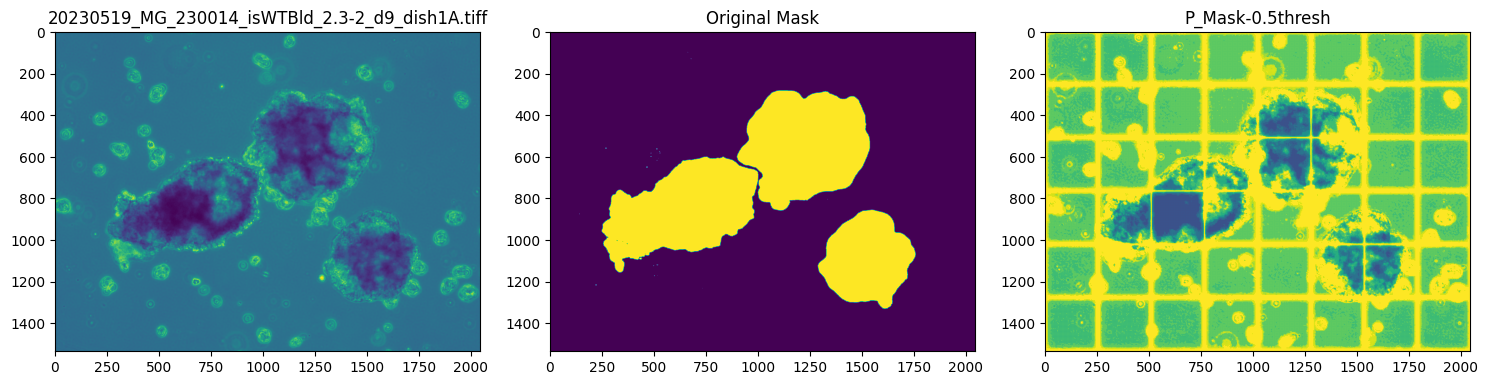

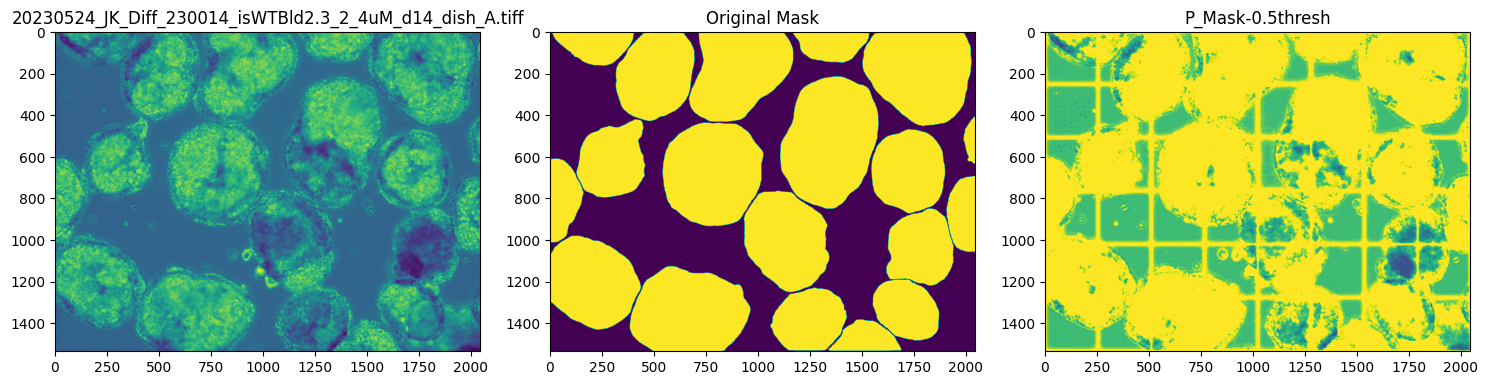

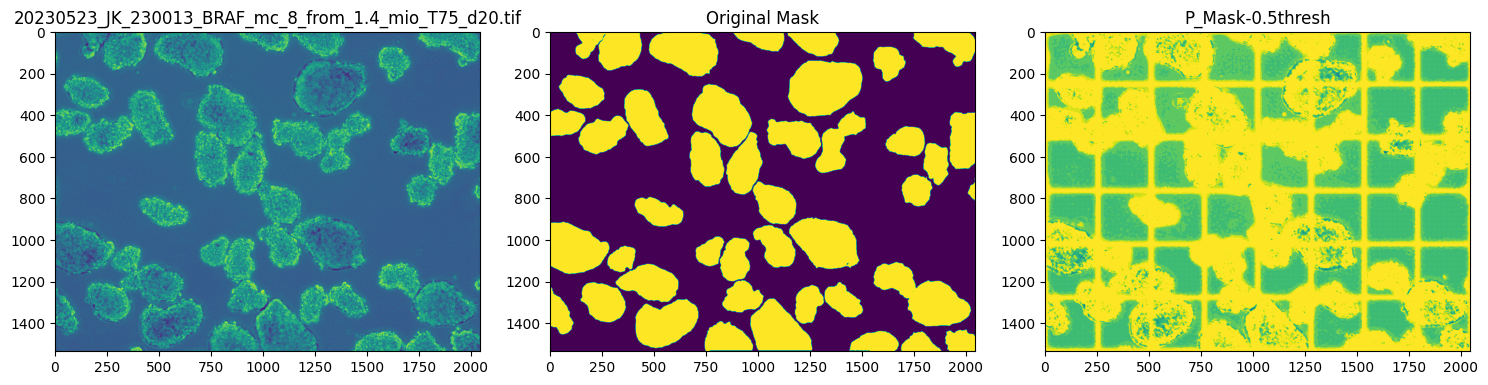

In [34]:

print("[INFO] load up model...")
## clear the GPU used 
Device = 'cuda:1' # or tery other devoces  if either of rhe devices are blocked
model.to(Device)
# unet = torch.load(MODEL_PATH).to(Device)
# unet = torch.load('/user/s.chakrabarty/myoTwinWork/code/EmbryonicBodySegmentation/bSz1_ip256_EnDc16-256_ep10_vls0.4_aug3_nW2_FullModel.pth').to(Device)
print("[INFO] loading up test image paths...\n")
test_input = '/user/s.chakrabarty/myoTwinWork/data/embryonicImages/test_inputs'
test_mask = '/user/s.chakrabarty/myoTwinWork/data/embryonicImages/test_masks'

files = os.listdir(test_input)
for file in files:
    if file == '.DS_Store': continue
    imagePath = test_input+ '/' + file
    groundTruthPath = test_mask + '/' + '.'.join(file.split('.')[:-1]) + '_bn.tif'
    # simg = make_predictions(unet, file, imagePath, groundTruthPath, PATCH_SIZE, threshold = 0.5)
    simg = make_predictions(model, file, imagePath, groundTruthPath, PATCH_SIZE, threshold = 0.5)



In [ ]:
gpu_usage()



| ID | GPU | MEM |
------------------
|  0 |  0% | 92% |
|  1 |  0% | 20% |
|  2 |  0% | 20% |
|  3 |  0% | 20% |
|  4 |  0% | 20% |
|  5 |  0% | 20% |
|  6 |  0% | 20% |
|  7 |  0% | 20% |
